# Determinar la nota final de los estudiantes

En principio se intentaba determinar la nota dependiendo √∫nicamente de las caracter√≠sticas sociales.
Tras el estudio se vi√≥ que salvo unas caracter√≠sticas muy espec√≠ficas la correlacionalidad no era lo suficientemente fuerte para determinar la nota, por lo que se integr√≥ la nota de escritura y lectura para poder determinar la de matem√°ticas por su fuerte correlaci√≥n. Se estudian modelos de √°rboles de decisi√≥n y modelos lineales para determinar cual es el modelo m√°s √≥ptimo. Cuando se utilizaban los datos √∫nicamente sociales se ve√≠a una fuerte linealidad en los datos por lo que se entiende que seguramente un modelo lineal ser√° el m√°s adecuado para este tipo de datos.

OBTENER LOS DATOS:

* El dataset que estoy utilizando pertenece a Kaggle y permite su uso, por lo que no necesito de ning√∫n permiso adicional.

In [ ]:
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el CSV desde la ruta Github
url="https://raw.githubusercontent.com/Aiadevop/math_student_grade/refs/heads/main/data/raw/StudentsPerformance.csv"
df = pd.read_csv(url)

# Mostrar las primeras filas
df.head(10)

gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   
5  female        group B          associate's degree      standard   
6  female        group B                some college      standard   
7    male        group B                some college  free/reduced   
8    male        group D                 high school  free/reduced   
9  female        group B                 high school  free/reduced   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  
5                    none          71             83             78  
6               completed          88             95             92  
7                    none          40             43             39  
8               completed          64             64             67  
9                    none          38             60             50

In [3]:
# Obtengo la informaci√≥n b√°sica del dataframe.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [4]:
# Resumen estad√≠stico:
df.describe()

math score  reading score  writing score
count  1000.00000    1000.000000    1000.000000
mean     66.08900      69.169000      68.054000
std      15.16308      14.600192      15.195657
min       0.00000      17.000000      10.000000
25%      57.00000      59.000000      57.750000
50%      66.00000      70.000000      69.000000
75%      77.00000      79.000000      79.000000
max     100.00000     100.000000     100.000000

In [5]:
# Estudio las variables categ√≥ricas para transformarlas a num√©ricas
# Lista de columnas categ√≥ricas
categorical_cols = [
    'gender',
    'race/ethnicity',
    'parental level of education',
    'lunch',
    'test preparation course'
]

# Mostrar los valores √∫nicos de cada columna
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].unique())



gender:
['female' 'male']

race/ethnicity:
['group B' 'group C' 'group A' 'group D' 'group E']

parental level of education:
["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']

lunch:
['standard' 'free/reduced']

test preparation course:
['none' 'completed']


In [6]:
df_rg = df.copy()

# 1. Limpiar nombres de columnas
df_rg.columns = (
    df_rg.columns
    .str.strip()
    .str.replace(" ", "_")
    .str.replace("'", "", regex=False)
    .str.replace("/", "_", regex=False)
)

# 2. Limpiar valores en celdas de tipo string
df_rg = df_rg.apply(lambda col: col.map(lambda x: x.strip().replace("'", "").replace(" ", "_") if isinstance(x, str) else x))

In [7]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

df_num = df_rg.copy()

# -----------------------------
# 1Ô∏è‚É£ Label Encoding para binarias
# -----------------------------
label_encoders = {
    'gender': {'female': 0, 'male': 1},
    'lunch': {'free/reduced': 0, 'standard': 1},
    'test_preparation_course': {'none': 0, 'completed': 1}
}

for col, mapping in label_encoders.items():
    df_num[col] = df_num[col].map(mapping)

# -----------------------------
# 2Ô∏è‚É£ One-Hot Encoding para variables multiclase
# -----------------------------
ohe_cols = ['race_ethnicity', 'parental_level_of_education']
ohe = OneHotEncoder(drop='first', sparse_output=False) # drop='first' evita multicolinealidad

ohe_result = ohe.fit_transform(df_num[ohe_cols])
ohe_df = pd.DataFrame(
    ohe_result,
    columns=ohe.get_feature_names_out(ohe_cols),
    index=df_num.index
)

# -----------------------------
# 3Ô∏è‚É£ Unir al DataFrame original y eliminar columnas originales
# -----------------------------
df_num = df_num.drop(columns=ohe_cols)
df_num = pd.concat([df_num, ohe_df], axis=1)

# -----------------------------
# 4Ô∏è‚É£ Reordenar las columnas por nivel de estudios.
# -----------------------------

edu_order = [
    "parental_level_of_education_some_high_school",
    "parental_level_of_education_high_school",
    "parental_level_of_education_some_college",
    "parental_level_of_education_bachelors_degree",
    "parental_level_of_education_masters_degree"
]

df_num = df_num[edu_order + [col for col in df_num.columns if col not in edu_order]]

In [8]:
df_num.head()

parental_level_of_education_some_high_school  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   parental_level_of_education_high_school  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   parental_level_of_education_some_college  \
0                                       0.0   
1                                       1.0   
2                                       0.0   
3                                       0.0   
4                                       1.0   

   parental_level_of_education_bachelors_degree  \
0                                           1.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   parental_level_of_education_masters_degree  gender  lunch  \
0                                         0.0       0      1   
1                                         0.0       0      1   
2                                         1.0       0      1   
3                                         0.0       1      0   
4                                         0.0       1      1   

   test_preparation_course  math_score  reading_score  writing_score  \
0                        0          72             72             74   
1                        1          69             90             88   
2                        0          90             95             93   
3                        0          47             57             44   
4                        0          76             78             75   

   race_ethnicity_group_B  race_ethnicity_group_C  race_ethnicity_group_D  \
0                     1.0                     0.0                     0.0   
1                     0.0                     1.0                     0.0   
2                     1.0                     0.0                     0.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     1.0                     0.0   

   race_ethnicity_group_E  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0

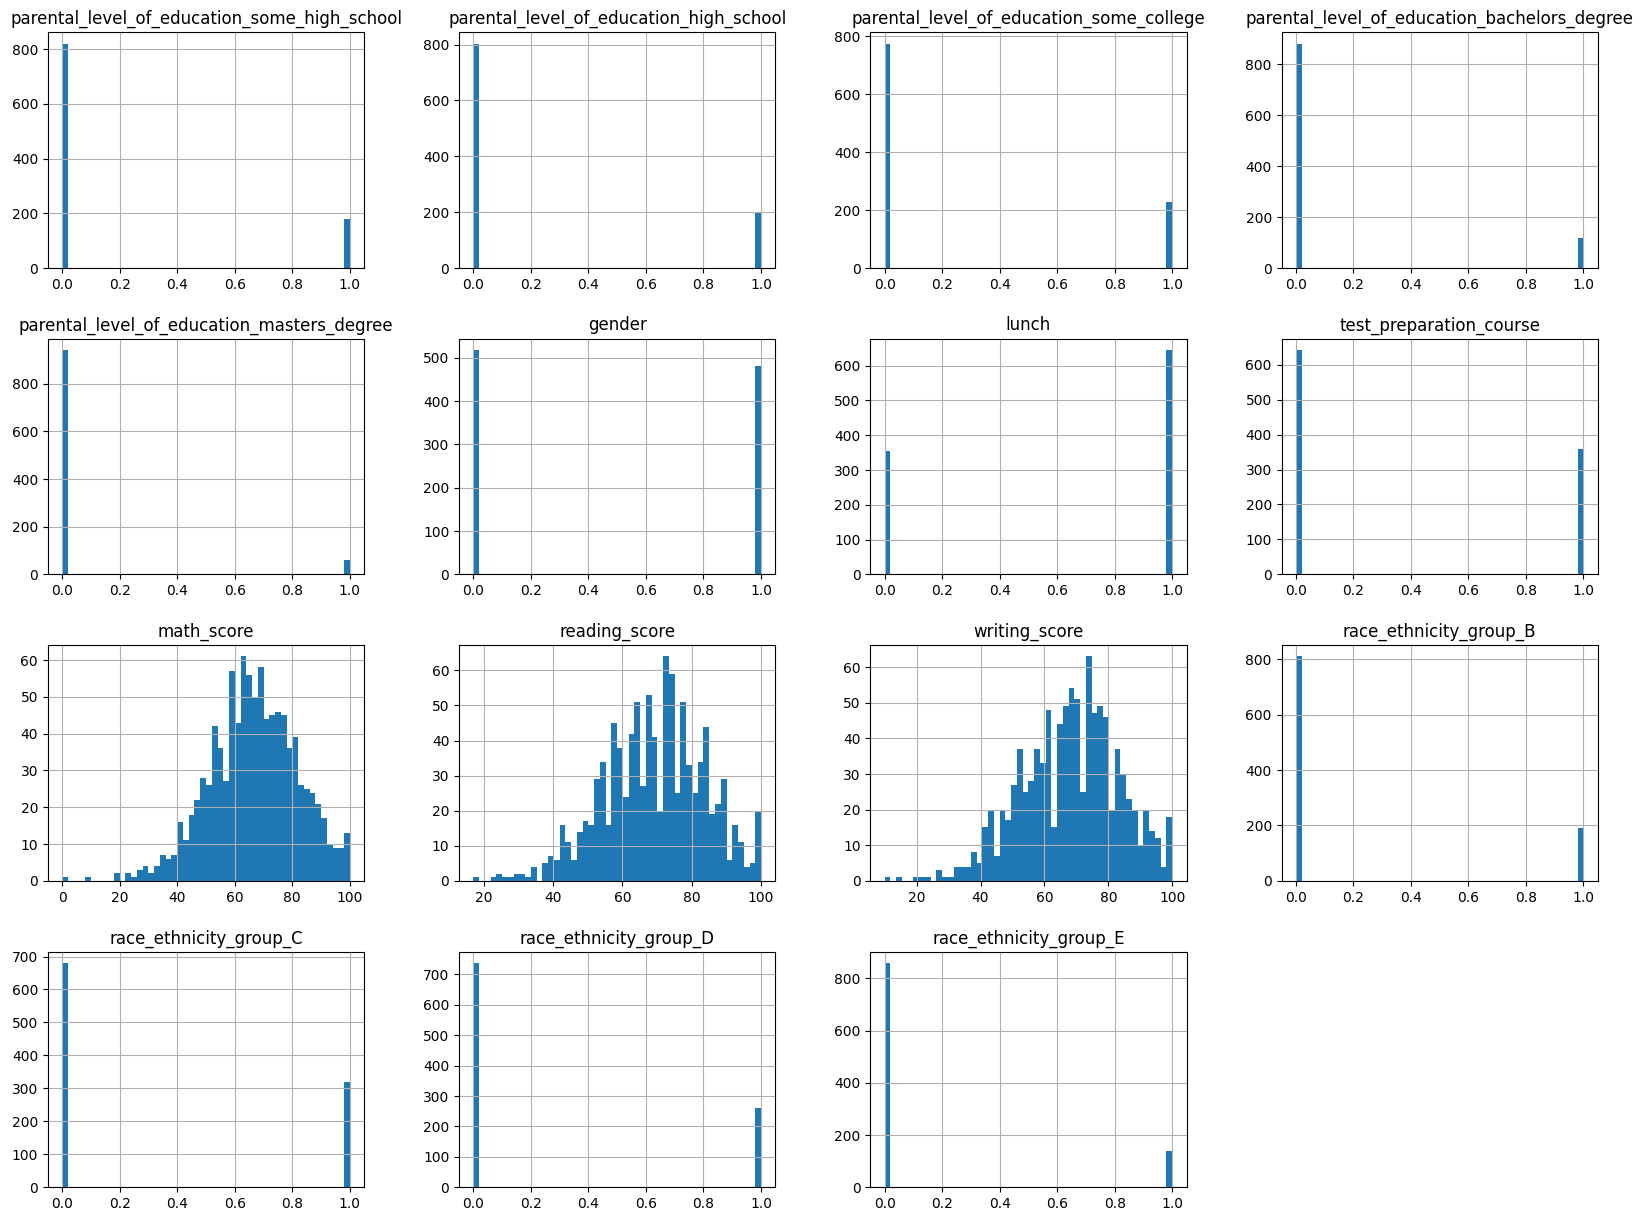

In [9]:
# sacamos las gr√°ficas de cada feature
import matplotlib.pyplot as plt

df_num.hist(bins=50, figsize=(20,15))
plt.show()

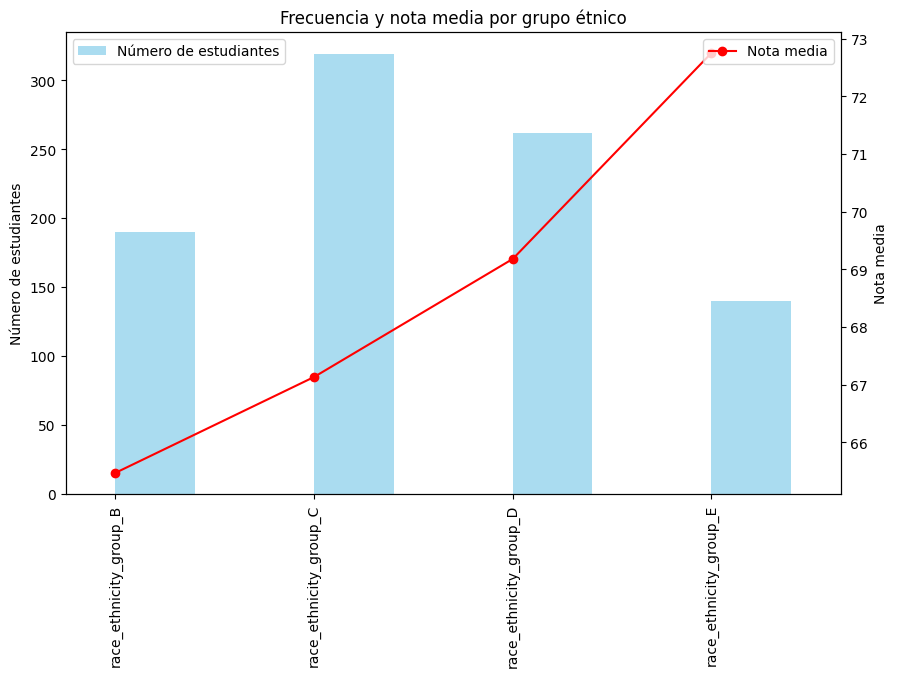

In [10]:
import matplotlib.pyplot as plt

ethnicity_cols = [
    "race_ethnicity_group_B", "race_ethnicity_group_C",
    "race_ethnicity_group_D", "race_ethnicity_group_E"
]

# --- Frecuencia de estudiantes por grupo ---
counts = df_num[ethnicity_cols].sum()

# --- Nota media por grupo (ejemplo con math_score, reading_score y writing_score) ---
mean_scores = {}
for col in ethnicity_cols:
    mask = df_num[col] == 1
    mean_scores[col] = df_num.loc[mask, ["math_score", "reading_score", "writing_score"]].mean().mean()

mean_scores = pd.Series(mean_scores)

# --- Gr√°fico combinado ---
fig, ax1 = plt.subplots(figsize=(10,6))

# Barras = n√∫mero de estudiantes
counts.plot(kind="bar", ax=ax1, color="skyblue", alpha=0.7, position=0, width=0.4, label="N√∫mero de estudiantes")

# Eje secundario para las notas
ax2 = ax1.twinx()
mean_scores.plot(kind="line", ax=ax2, color="red", marker="o", label="Nota media")

# T√≠tulos y etiquetas
ax1.set_title("Frecuencia y nota media por grupo √©tnico")
ax1.set_ylabel("N√∫mero de estudiantes")
ax2.set_ylabel("Nota media")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

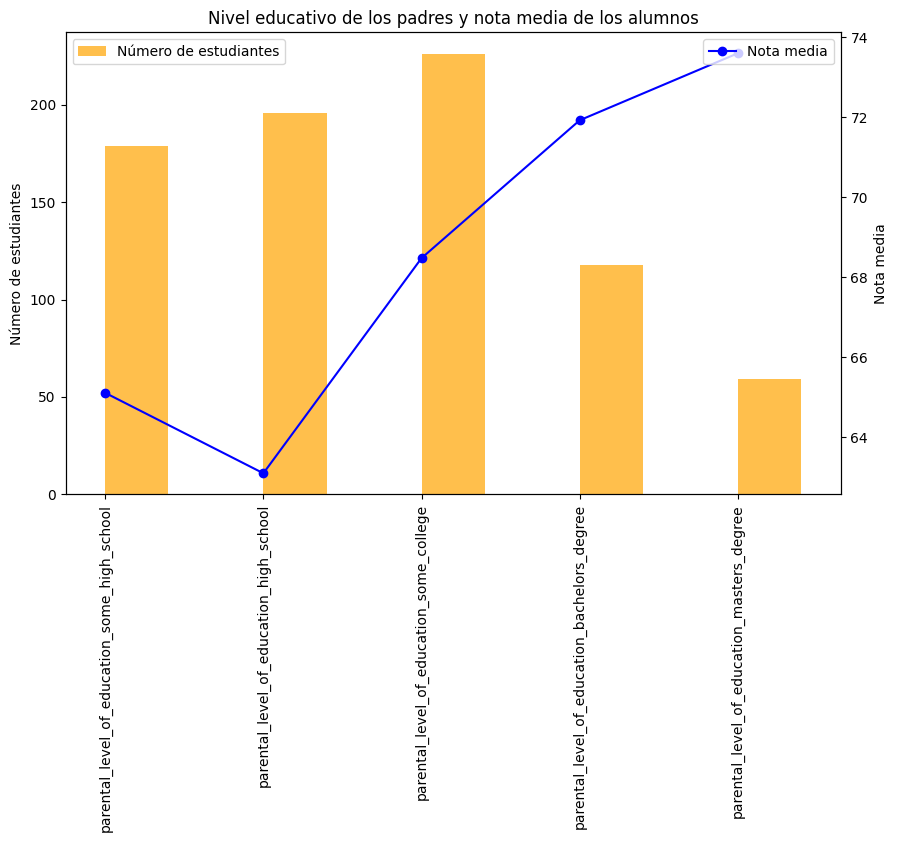

In [11]:
import matplotlib.pyplot as plt

edu_cols = [
    "parental_level_of_education_some_high_school",
    "parental_level_of_education_high_school",
    "parental_level_of_education_some_college",
    "parental_level_of_education_bachelors_degree",
    "parental_level_of_education_masters_degree"
]

# --- Frecuencia de estudiantes por nivel educativo ---
counts = df_num[edu_cols].sum()

# --- Nota media por nivel educativo (promedio de math, reading y writing) ---
mean_scores = {}
for col in edu_cols:
    mask = df_num[col] == 1
    mean_scores[col] = df_num.loc[mask, ["math_score", "reading_score", "writing_score"]].mean().mean()

mean_scores = pd.Series(mean_scores)

# --- Gr√°fico combinado ---
fig, ax1 = plt.subplots(figsize=(10,6))

# Barras = n√∫mero de estudiantes
counts.plot(kind="bar", ax=ax1, color="orange", alpha=0.7, position=0, width=0.4, label="N√∫mero de estudiantes")

# Eje secundario para las notas
ax2 = ax1.twinx()
mean_scores.plot(kind="line", ax=ax2, color="blue", marker="o", label="Nota media")

# T√≠tulos y etiquetas
ax1.set_title("Nivel educativo de los padres y nota media de los alumnos")
ax1.set_ylabel("N√∫mero de estudiantes")
ax2.set_ylabel("Nota media")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()


- De estas gr√°ficas se deduce que:
  * La distribuci√≥n de genero es bastante igualitaria.
  * Hay casi el doble de alumnos con almuerzo regular que con almuerzo reducido.
  * Mayor√≠a de los alumnos no prepararon el test inicial
  * Hay una etnia fuertemente predominante la C y una etnia mucho menos predominante E, pero que obtiene la mayor nota media, la del B la que menor nota media obtiene.
  * Hay menor n√∫mero de padres cuanto m√°s alto es el nivel de estudios, pero se obtiene mejor nota a medida que ascienden los estudios de los padres.  

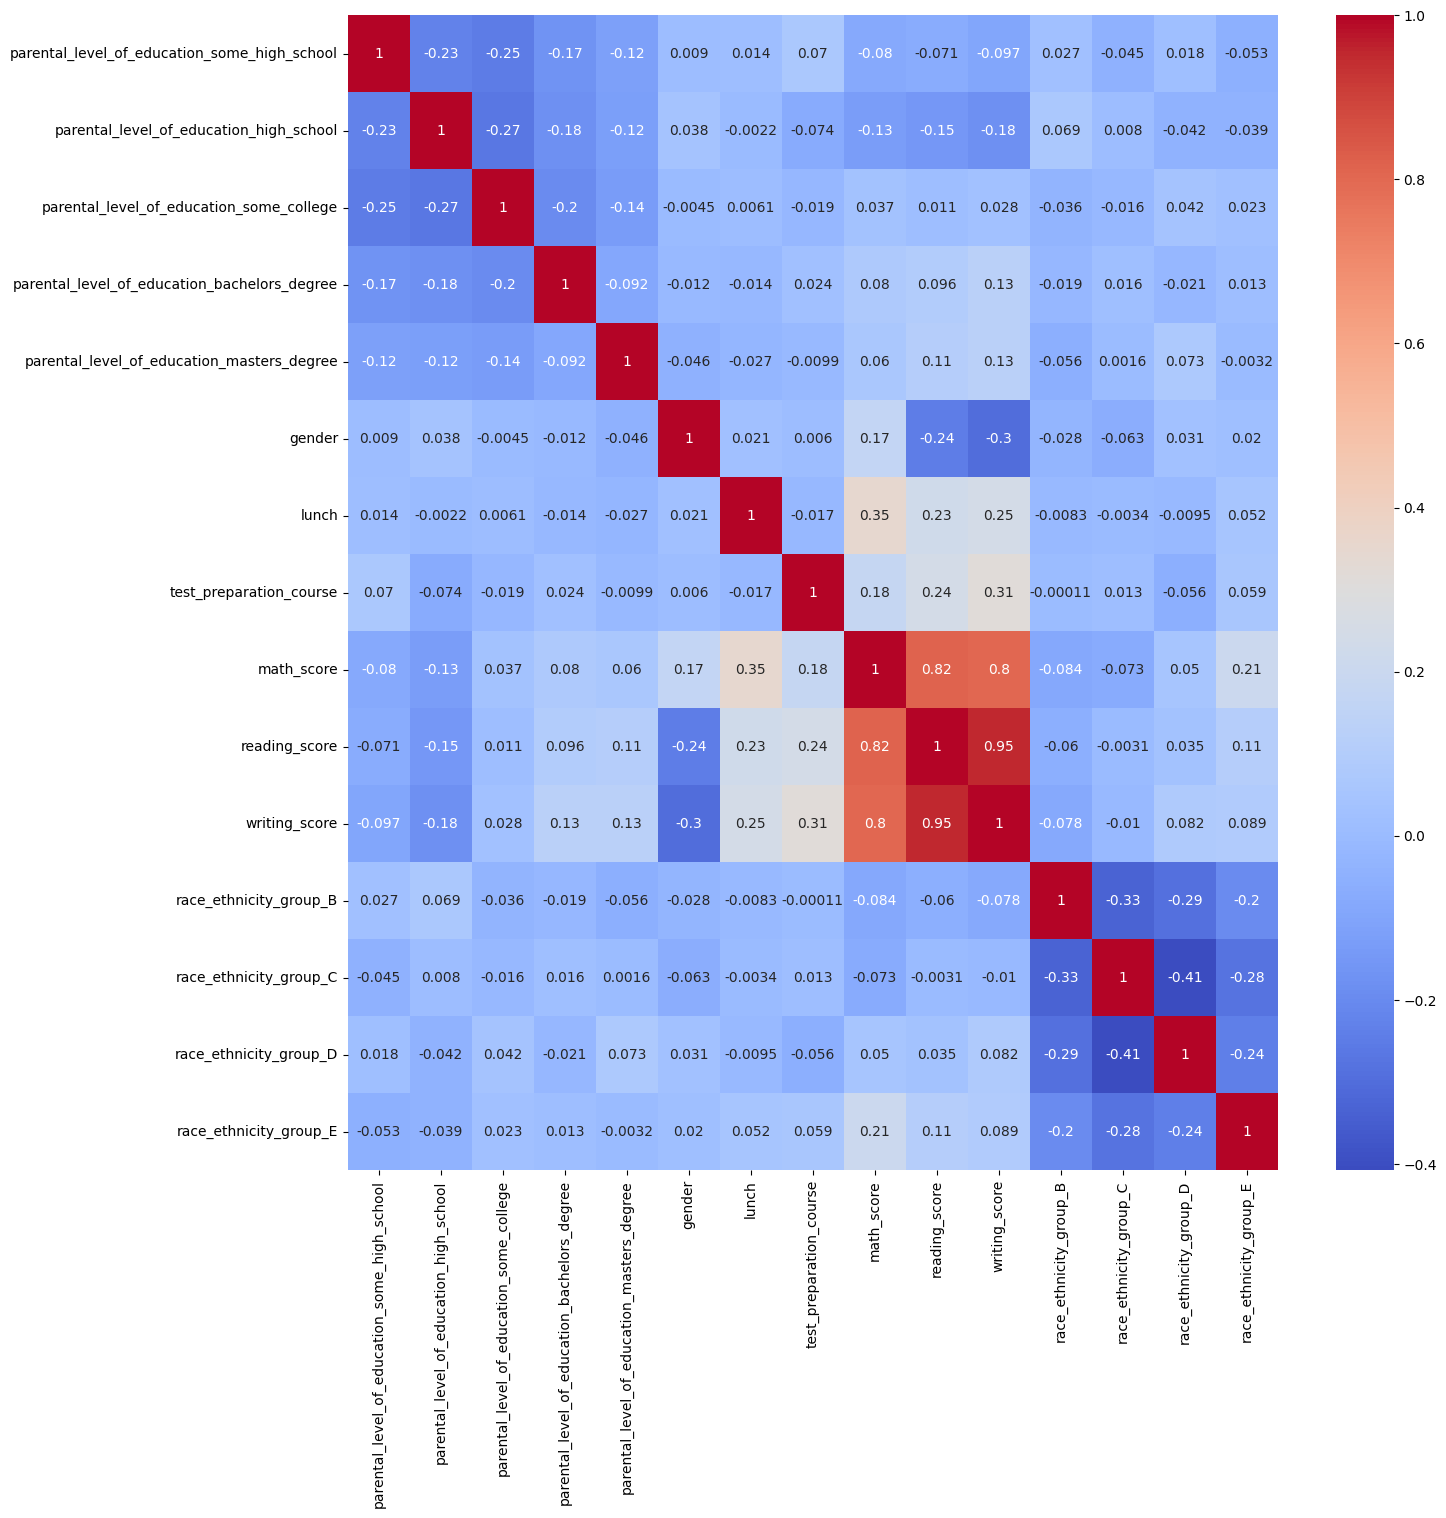

In [12]:
# Mapa de calor.
co_mx= df_num.corr()
# print(co_mx)
plt.figure(figsize= (15,15))
sns.heatmap(co_mx, annot=True , cmap = 'coolwarm')
plt.show()

In [13]:
# 1Ô∏è‚É£ Correlaci√≥n de todas las variables con math_score
corr_target = df_num.corr()['math_score'].sort_values(ascending=False)

# Vemos correlaciones con math_score
print(corr_target)

# 2Ô∏è‚É£ Fijamos un umbral para considerar "variables relevantes"
#    (ejemplo: |corr| > 0.1, t√∫ puedes ajustar el valor)
umbral = 0.1
features_relevantes = corr_target[abs(corr_target) > umbral].index.tolist()

# Nos aseguramos de incluir math_score (target)
if 'math_score' not in features_relevantes:
    features_relevantes.append('math_score')

# 3Ô∏è‚É£ DataFrame para regresi√≥n lineal (solo features relevantes)
df_linear = df_num[features_relevantes].copy()

# 4Ô∏è‚É£ DataFrame para √°rboles (todas las features, no filtramos nada)
df_tree = df_num.copy()

# 5Ô∏è‚É£ Guardamos los dos dataframes
print("üìä DataFrame para regresi√≥n lineal:")
display(df_linear.head())

print("\nüå≥ DataFrame para √°rboles:")
display(df_tree.head())


math_score                                      1.000000
reading_score                                   0.817580
writing_score                                   0.802642
lunch                                           0.350877
race_ethnicity_group_E                          0.205855
test_preparation_course                         0.177702
gender                                          0.167982
parental_level_of_education_bachelors_degree    0.079664
parental_level_of_education_masters_degree      0.060417
race_ethnicity_group_D                          0.050071
parental_level_of_education_some_college        0.037056
race_ethnicity_group_C                         -0.073387
parental_level_of_education_some_high_school   -0.079852
race_ethnicity_group_B                         -0.084250
parental_level_of_education_high_school        -0.128725
Name: math_score, dtype: float64
üìä DataFrame para regresi√≥n lineal:


math_score  reading_score  writing_score  lunch  race_ethnicity_group_E  \
0          72             72             74      1                     0.0   
1          69             90             88      1                     0.0   
2          90             95             93      1                     0.0   
3          47             57             44      0                     0.0   
4          76             78             75      1                     0.0   

   test_preparation_course  gender  parental_level_of_education_high_school  
0                        0       0                                      0.0  
1                        1       0                                      0.0  
2                        0       0                                      0.0  
3                        0       1                                      0.0  
4                        0       1                                      0.0


üå≥ DataFrame para √°rboles:


parental_level_of_education_some_high_school  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   parental_level_of_education_high_school  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   parental_level_of_education_some_college  \
0                                       0.0   
1                                       1.0   
2                                       0.0   
3                                       0.0   
4                                       1.0   

   parental_level_of_education_bachelors_degree  \
0                                           1.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   parental_level_of_education_masters_degree  gender  lunch  \
0                                         0.0       0      1   
1                                         0.0       0      1   
2                                         1.0       0      1   
3                                         0.0       1      0   
4                                         0.0       1      1   

   test_preparation_course  math_score  reading_score  writing_score  \
0                        0          72             72             74   
1                        1          69             90             88   
2                        0          90             95             93   
3                        0          47             57             44   
4                        0          76             78             75   

   race_ethnicity_group_B  race_ethnicity_group_C  race_ethnicity_group_D  \
0                     1.0                     0.0                     0.0   
1                     0.0                     1.0                     0.0   
2                     1.0                     0.0                     0.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     1.0                     0.0   

   race_ethnicity_group_E  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0

In [14]:
from google.colab import files

# Guarda el DataFrame como CSV
df_linear.to_csv('df_linear.csv', index=False)

# Descarga el archivo
files.download('df_linear.csv')

# Guarda el DataFrame como CSV
df_tree.to_csv('df_tree.csv', index=False)

# Descarga el archivo
files.download('df_tree.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>